# Section 5.2: SODEN Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement SODEN (Tang et al., 2022) using PyTorch, snippets of the original SODEN code by Tang et al. (2022), and `torchdiffeq`. For an overview of how SODEN works, please see Sections 5.1 and 5.2 in the monograph (the training and prediction procedures are specifically in Section 5.2). This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail.

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the SODEN model

In [4]:
import torch
import torch.nn as nn
from SODEN.models import BaseSurvODEFunc

torch.manual_seed(0)

num_input_features = X_train.size(1)

# The base neural net takes in `num_input_features` + 2 inputs; in particular,
# the inputs are:
# - t (a nonnegative number)
# - H(t|x) (a nonnegative number)
# - x (consists of `num_input_features` numbers)
# The output is a single positive number for the hazard (to ensure that it's
# positive, we use softplus activation)
base_neural_net = nn.Sequential(nn.Linear(num_input_features + 2, 8),
                                nn.ReLU(),
                                nn.Linear(8, 1),
                                nn.Softplus()).to(device)

# the rest of the code in this cell is to basically glue/wrapper code so that we
# can use the base neural net with SODEN

# ------------------------------------------------------------------------------
# The following class is copied from the `ContextRecMLPODEFunc` class in:
#   https://github.com/jiaqima/SODEN/blob/main/models.py
# The only change is just that this version accepts a user-specified base neural
# net rather than the code creating its own base neural net.
class ODEFunc(BaseSurvODEFunc):
    def __init__(self, base_neural_net, num_features):
        super(ODEFunc, self).__init__()
        self.net = base_neural_net
        self.feature_size = num_features

    def forward(self, t, y):
        """
        Arguments:
          t: When self.batch_time_mode is False, t is a scalar indicating the
            time step to be evaluated. When self.batch_time_mode is True, t is
            a 1-D tensor with a single element [1.0].
          y: When self.batch_time_mode is False, y is a 1-D tensor with length
            2 + k, where the first dim indicates Lambda_t, the second dim
            indicates the final time step T to be evaluated, and the remaining
            k dims indicates the features. When self.batch_time_mode is True, y
            is a 2-D tensor with batch_size * (2 + k).
        """
        self.nfe += 1
        device = next(self.parameters()).device
        Lambda_t = y.index_select(-1, torch.tensor([0]).to(device)).view(-1, 1)
        T = y.index_select(-1, torch.tensor([1]).to(device)).view(-1, 1)
        x = y.index_select(-1, torch.tensor(range(2, y.size(-1))).to(device))
        # Rescaling trick
        # $\int_0^T f(s; x) ds = \int_0^1 T f(tT; x) dt$, where $t = s / T$
        inp = torch.cat(
            [Lambda_t,
             t.repeat(T.size()) * T,  # s = t * T
             x.view(-1, self.feature_size)], dim=1)
        output = self.net(inp) * T  # f(tT; x) * T
        zeros = torch.zeros_like(
            y.index_select(-1, torch.tensor(range(1, y.size(-1))).to(device))
        )
        output = torch.cat([output, zeros], dim=1)
        if self.batch_time_mode:
            return output
        else:
            return output.squeeze(0)
# ------------------------------------------------------------------------------

# wrapper to work with `odeint` from the `torchdiffeq` package
ode_func = ODEFunc(base_neural_net, num_input_features)

### Setting up the SODEN loss

In [5]:
def ode_loss(X_batch, Y_batch, D_batch):
    # for every data point, we integrate starting from time 0
    all_zeros = torch.zeros(X_batch.size(0), dtype=torch.float, device=device)

    init_cond = torch.cat([all_zeros.view(-1, 1),
                           Y_batch.view(-1, 1),
                           X_batch],
                          dim=1)

    # we integrate from 0 (time 0) to 1 (the observed time per data point)
    t = torch.tensor([0., 1.]).to(device)

    # here's code to call the ODE solver
    ode_func.set_batch_time_mode(False)
    cumulative_hazards = \
        odeint(ode_func, init_cond, t, rtol=1e-4, atol=1e-8)[1:].squeeze()
    # note: the reason [1:].squeeze() shows up is as follows:
    # - the output of odeint is an iterable where the 0th element corresponds
    #   `t[0]` and the 1st element corresponds to `t[1]`
    # - by using the indexing `[1:]`, we are saying that we want the
    #   cumulative hazards at `t[1]`, which corresponds to the cumulative
    #   hazard evaluated at the observed time per data point
    # - after applying the indexing `[1;]`, the 0th dimension is no longer
    #   needed so we use `squeeze()` to get rid of it
    ode_func.set_batch_time_mode(True)

    # now we can evaluate the ODE function to get the hazards
    hazards = ode_func(t[1:], cumulative_hazards).squeeze()

    # some reformatting of the output
    cumulative_hazards = cumulative_hazards[:, 0]
    hazards = hazards[:, 0] / Y_batch.view(-1, 1)

    # use a clamp to avoid log 0
    log_hazards = torch.log(hazards.clamp(min=1e-8))

    # the loss is precisely L_{SODEN-NLL} in Section 5.2 of the monograph
    loss_batch = (-D_batch.view(-1, 1) * log_hazards
                  + cumulative_hazards).mean()
    return loss_batch

### Training the model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [6]:
from copy import deepcopy
from torch.utils.data import DataLoader
from torchdiffeq import odeint_adjoint as odeint

# minibatch gradient descent
num_epochs = 10
batch_size = 128
learning_rate = 1e-2

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        loss_batch = ode_loss(X_batch, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            train_loss += ode_loss(X_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            val_loss += ode_loss(X_batch, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 10.87423038482666 - val loss 10.589367866516113
Epoch 2 - train loss 10.071709632873535 - val loss 9.864890098571777
Epoch 3 - train loss 8.400647163391113 - val loss 8.180248260498047
Epoch 4 - train loss 4.833189487457275 - val loss 4.7748613357543945
Epoch 5 - train loss 4.5473785400390625 - val loss 4.480245113372803
Epoch 6 - train loss 4.529810428619385 - val loss 4.461924076080322
Epoch 7 - train loss 4.4411420822143555 - val loss 4.364966869354248
Epoch 8 - train loss 4.406889915466309 - val loss 4.325331211090088
Epoch 9 - train loss 4.404280185699463 - val loss 4.3172831535339355
Epoch 10 - train loss 4.43654203414917 - val loss 4.34867000579834
Best validation loss (4.3172831535339355) achieved at epoch 9


<All keys matched successfully>

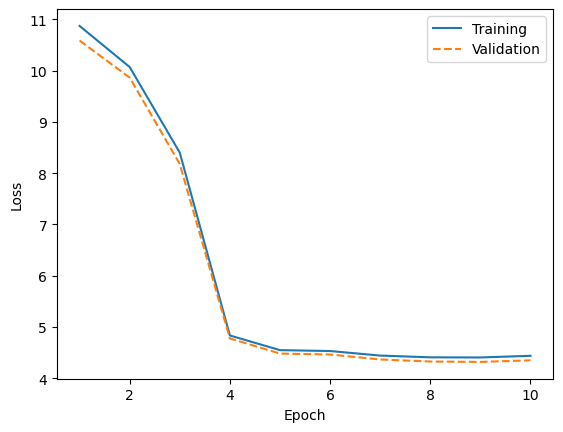

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [8]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')
X_test_np.shape

(2662, 19)

Importantly, in our demos for other models, we would typically train a survival model, and the trained model would use a time grid based on training data. When we evaluate on test data and try to use the observed times from the test data, there would be some interpolation needed (since often the observed times in test data are not exactly the same as the ones in training data).

For SODEN, since the model is inherently continuous, we can just predict at whichever times we want, so we can directly just predict at, for instance, the unique observed times in the test data.

In [9]:
import numpy as np
time_grid_np_test_np = np.unique(Y_test_np)

In [10]:
def ode_predict(X_batch, time_grid_np):
    with torch.no_grad():
        inserted_0 = False
        if time_grid_np[0] != 0:
            time_grid_np = np.insert(time_grid_np, 0, 0)
            inserted_0 = True

        max_time = time_grid_np.max()
        time_grid_rescaled_np = time_grid_np / max_time
    
        # for every data point, we integrate starting from time 0 and we integrate
        # to the max time
        all_zeros = torch.zeros(X_batch.size(0), dtype=torch.float, device=device)
        all_max = max_time * \
            torch.ones(X_batch.size(0), dtype=torch.float, device=device)
    
        init_cond = torch.cat([all_zeros.view(-1, 1),
                               all_max.view(-1, 1),
                               X_batch],
                              dim=1)
    
        # we integrate from 0 (time 0) to 1 (the observed time per data point)
        t = torch.tensor(time_grid_rescaled_np, dtype=torch.float32).to(device)
    
        # here's code to call the ODE solver
        ode_func.set_batch_time_mode(False)
        cumulative_hazards = \
            odeint(ode_func, init_cond, t, rtol=1e-4, atol=1e-8)
        ode_func.set_batch_time_mode(True)

        if inserted_0:
            # ignore the 0th time which is 0
            return cumulative_hazards[1:, :, 0]
        else:
            return cumulative_hazards[:, :, 0]
        # output shape = (original time grid length, number of points)

In [11]:
cumulative_hazards_test = ode_predict(torch.from_numpy(X_test_np).to(device), time_grid_np_test_np)
cumulative_hazards_test.size()

torch.Size([1061, 2662])

We can easily back out survival functions:

In [12]:
surv_test_np = np.exp(-cumulative_hazards_test.cpu().numpy().T)

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

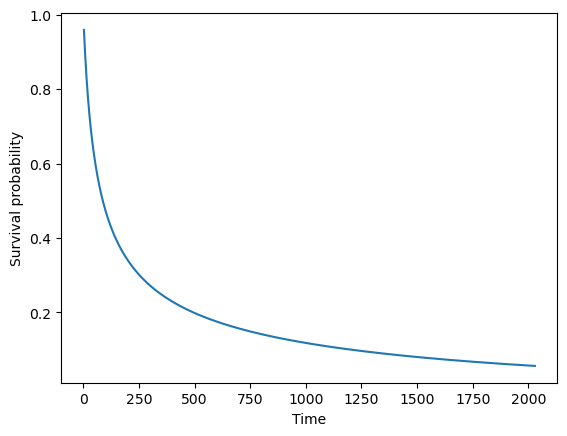

In [13]:
plt.plot(time_grid_np_test_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [14]:
import pandas as pd
from pycox.evaluation import EvalSurv

# PyCox's EvalSurv expects the predicted test data's survival functions to be in
# a Pandas DataFrame where the rows index time, and the columns index data points
surv_test_df = pd.DataFrame(surv_test_np.T, index=time_grid_np_test_np)
eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')

print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.5999961596954834


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [15]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_np_test_np)),
                     int(.5 * len(time_grid_np_test_np)),
                     int(.75 * len(time_grid_np_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_np_test_np[eval_time_index]
    surv_values_at_eval_time_np = surv_test_np[:, eval_time_index]
    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6003177723541635
Eval time 693.0 - truncated time-dependent concordance: 0.6000619206152142
Eval time 1291.0 - truncated time-dependent concordance: 0.5965819731040101


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [16]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_np_test_np[eval_time_index]

    # find the interpolated time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_np_test_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6427538523851566
Eval time 693.0 - time-dependent AUC: 0.6553645331114935
Eval time 1291.0 - time-dependent AUC: 0.6485517166931463


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [17]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_np_test_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_np_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.2361933262739466


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.21787226061435294
Eval time 1291.0 - Brier score: 0.20312653778237788
Integrated Brier score: 0.20095424799187958


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [18]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [19]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 616.4241960737193


In [20]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 734.9082637692605
